## Logistic Regression Classifier

### Data Preprocessing
Loads the IMDB dataset using TensorFlow's Keras module, creating training, validation and testing sets. It further maps numeric sequences to human-readable text.

In [1]:
m = 3000    # Number of words in the vocabulary
n = 20      # N most frequent words to skip
k = 20      # K least frequent words to skip

In [2]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=m-k, skip_top=n)

x_train, x_dev, y_train, y_dev = train_test_split(x_train, y_train, test_size=0.2)

word_index = tf.keras.datasets.imdb.get_word_index()

index2word = dict((i + 3, word) for (word, i) in word_index.items())
index2word[0] = '[pad]'
index2word[1] = '[bos]'
index2word[2] = '[oov]'

x_train = np.array([' '.join([index2word[idx] for idx in text]) for text in x_train])
x_dev = np.array([' '.join([index2word[idx] for idx in text]) for text in x_dev])
x_test = np.array([' '.join([index2word[idx] for idx in text]) for text in x_test])

### Binary Vector Creation
Transforms the textual movie reviews into binary bag-of-words representations, indicating the presence (1) or absence (0) of words using scikit-learn's CountVectorizer.

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

binary_vectorizer = CountVectorizer(binary=True)
x_train_binary = binary_vectorizer.fit_transform(x_train)
x_dev_binary = binary_vectorizer.fit_transform(x_dev)
x_test_binary = binary_vectorizer.transform(x_test)

x_train_binary = x_train_binary.toarray()
x_dev_binary = x_dev_binary.toarray()
x_test_binary = x_test_binary.toarray()

### Visualizations

In [12]:
import numpy as np
from matplotlib import pyplot as plt
from pandas import DataFrame
from sklearn.metrics import (auc, confusion_matrix, f1_score,
                             precision_score, recall_score, roc_curve)


def evaluate_estimator(estimator, x_train, y_train, x_test, y_test, splits=5):
    train_precisions, test_precisions = [], []
    train_recall, test_recall, train_f1, test_f1 = [], [], [], []
    split_size = len(x_train) // splits

    for i in range(1, splits + 1):
        x_train_split, y_train_split = x_train[:i * split_size], y_train[:i * split_size]
        estimator.fit(x_train_split, y_train_split)

        train_pred, test_pred = estimator.predict(x_train_split), estimator.predict(x_test)

        train_precisions.append(precision_score(y_train_split, train_pred))
        test_precisions.append(precision_score(y_test, test_pred))

        train_recall.append(recall_score(y_train_split, train_pred))
        test_recall.append(recall_score(y_test, test_pred))

        train_f1.append(f1_score(y_train_split, train_pred))
        test_f1.append(f1_score(y_test, test_pred))

    cm = confusion_matrix(y_test, test_pred)

    return {'estimator': estimator.__class__.__name__,
            'split_size': split_size,
            'splits': splits,
            'test_pred': test_pred,
            'train_precision': train_precisions,
            'test_precision': test_precisions,
            'train_recall': train_recall,
            'test_recall': test_recall,
            'train_f1': train_f1,
            'test_f1': test_f1,
            'confusion_matrix': cm}         

def plot_metrics_table(evaluate_metrics):
    """
    Creates and displays a table of the train/test accuracies, precisions, recalls,
    and F1 scores for each split. 

    Arguments:
      evaluate_metrics: The dictionary containing the train/test data metrics.
    """
    num_splits = evaluate_metrics['splits']
    split_size = evaluate_metrics['split_size']

    df = DataFrame({
        f'{metric} {data_type}': np.round(evaluate_metrics[f'{data_type.lower()}_{metric.lower()}'], 2)
        for metric in ['Precision', 'Recall', 'F1']
        for data_type in ['Train', 'Test']
    }, index=list(range(split_size, split_size * (num_splits + 1), split_size)))

    display(df)

def plot_roc_curve(y_true, y_scores, label='Classifier'):
  """
  Plot the ROC curve for a binary classification model.

  Parameters:
    - y_true: True labels (ground truth).
    - y_scores: Predicted scores or probabilities for the positive class.
    - label (optional): Label for the classifier (default is 'Classifier').
  """
  
  fpr, tpr, thresholds = roc_curve(y_true, y_scores)
  roc_auc = auc(fpr, tpr)

  plt.figure(figsize=(8, 8))
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'{label} (AUC = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.title('ROC Curve')
  plt.legend(loc='lower right')
  plt.show()

def plot_learning_curves(classification_data):
  """
  Visualize both normal and zoomed learning curves of accuracy, precision, recall, and F1 for training and testing sets.

  Arguments:
    classification_data: The dictionary containing the train/test data.
  """
  num_splits = classification_data['splits']
  split_size = classification_data['split_size']

  x_values = list(range(split_size, split_size * (num_splits + 1), split_size))

  metrics = ['Precision', 'Recall', 'F1']

  for metric in metrics:
      # Create a new figure for each metric
      plt.figure(figsize=(7, 4))

      # Plot normal learning curves
      plt.subplot(1, 2, 1)
      plt.plot(x_values, classification_data[f'train_{metric.lower()}'], label='Train')
      plt.plot(x_values, classification_data[f'test_{metric.lower()}'], label='Test')
      plt.title(f'{metric}')
      plt.xticks(x_values)
      plt.ylim(0.0 - 0.1, 1.0 + 0.1)
      plt.legend()

      # Plot zoomed learning curves
      plt.subplot(1, 2, 2)
      plt.plot(x_values, classification_data[f'train_{metric.lower()}'], label='Train')
      plt.plot(x_values, classification_data[f'test_{metric.lower()}'], label='Test')
      plt.title(f'{metric} (Zoomed In)')
      plt.xticks(x_values)

      # Calculate y-axis limits based on the range of y-values for each metric
      y_min = min(min(classification_data[f'train_{metric.lower()}']), min(classification_data[f'test_{metric.lower()}']))
      y_max = max(max(classification_data[f'train_{metric.lower()}']), max(classification_data[f'test_{metric.lower()}']))
      y_range = y_max - y_min
      plt.ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)

      plt.suptitle(f"Learning Curve for {classification_data['estimator']} - {metric}", fontsize=16)
      plt.gcf().supxlabel('Training Examples', ha='center', fontsize=10)
      plt.tight_layout(rect=[0, 0, 1, 0.98])
      plt.show()

def plot_metrics_table_differences(classifier1_data, classifier2_data):
    """
    Creates and displays a table of the differences in train/test accuracies, precisions, recalls,
    and F1 scores between two classifiers for each split.

    Arguments:
      classifier1_data: Dictionary containing train/test data for classifier 1.
      classifier2_data: Dictionary containing train/test data for classifier 2.
    """
    num_splits = classifier1_data['splits']
    split_size = classifier1_data['split_size']

    df = DataFrame({
        f'{metric} {data_type}': np.round(classifier1_data[f'{data_type.lower()}_{metric.lower()}'], 2) - np.round(classifier2_data[f'{data_type.lower()}_{metric.lower()}'], 2)
        for metric in ['Precision', 'Recall', 'F1']
        for data_type in ['Train', 'Test']
    }, index=list(range(split_size, split_size * (num_splits + 1), split_size)))

    display(df)

def plot_learning_curve_differences(classifier1_data, classifier2_data):
    """
    Visualize the differences between two classifiers and their learning curves for accuracy, precision, recall, and F1.

    Arguments:
      classifier1_data: Dictionary containing train/test data for classifier 1.
      classifier2_data: Dictionary containing train/test data for classifier 2.
    """

    num_splits = classifier1_data['splits']
    split_size = classifier1_data['split_size']
    x_values = list(range(split_size, split_size * (num_splits + 1), split_size))

    for metric in ['Precision', 'Recall', 'F1']:
        plt.figure(figsize=(8, 4))

        # Plot normal learning curves for both classifiers
        plt.subplot(1, 2, 1)
        plt.plot(x_values, classifier1_data[f'train_{metric.lower()}'], label=f"{classifier1_data['estimator']} (Train)")
        plt.plot(x_values, classifier1_data[f'test_{metric.lower()}'], label=f"{classifier1_data['estimator']} (Test)")
        plt.plot(x_values, classifier2_data[f'train_{metric.lower()}'], label=f"{classifier2_data['estimator']} (Train)")
        plt.plot(x_values, classifier2_data[f'test_{metric.lower()}'], label=f"{classifier2_data['estimator']} (Test)")
        plt.title(metric)
        plt.ylim(0.0 - 0.1, 1.0 + 0.1)
        plt.legend()

        # Plot zoomed-in learning curves for both classifiers
        plt.subplot(1, 2, 2)
        plt.plot(x_values, classifier1_data[f'train_{metric.lower()}'], label=f"{classifier1_data['estimator']} (Train)")
        plt.plot(x_values, classifier1_data[f'test_{metric.lower()}'], label=f"{classifier1_data['estimator']} (Test)")
        plt.plot(x_values, classifier2_data[f'train_{metric.lower()}'], label=f"{classifier2_data['estimator']} (Train)")
        plt.plot(x_values, classifier2_data[f'test_{metric.lower()}'], label=f"{classifier2_data['estimator']} (Test)")
        plt.title(f'{metric} (Zoomed In)')

        # Calculate y-axis limits based on the range of y-values for each metric
        y_min_cl1 = min(min(classifier1_data[f'train_{metric.lower()}']), min(classifier1_data[f'test_{metric.lower()}']))
        y_max_cl1 = max(max(classifier1_data[f'train_{metric.lower()}']), max(classifier1_data[f'test_{metric.lower()}']))
        y_min_cl2 = min(min(classifier2_data[f'train_{metric.lower()}']), min(classifier2_data[f'test_{metric.lower()}']))
        y_max_cl2 = max(max(classifier2_data[f'train_{metric.lower()}']), max(classifier2_data[f'test_{metric.lower()}']))
        y_min = min(y_min_cl1, y_min_cl2)
        y_max = max(y_max_cl1, y_max_cl2)
        y_range = y_max - y_min
        plt.ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)

        plt.suptitle(f"{metric} Differences {classifier1_data['estimator']} - {classifier2_data['estimator']} (scikit)", fontsize=16)
        plt.gcf().supxlabel('Training Examples', ha='center', fontsize=10)
        plt.tight_layout(rect=[0, 0, 1, 0.98])
        plt.show()


### Logistic Regression Classifier Implementation


In [7]:
import numpy as np
from sklearn.utils import shuffle

class LogisticRegressionSGD:
    def __init__(self, learning_rate=0.01, num_epochs=1000, lambda_value=0.001, threshold=0.5, tol=1e-4, patience=5):
        # Initialize logistic regression parameters
        self.learning_rate = learning_rate  # Learning rate for gradient descent
        self.num_epochs = num_epochs  # Maximum number of training epochs
        self.lambda_value = lambda_value  # Regularization parameter
        self.threshold = threshold  # Threshold for binary classification
        self.tol = tol  # Tolerance for early stopping
        self.patience = patience  # Patience for early stopping
        self.weights = None  # Model weights

    def sigmoid(self, x):
        # Sigmoid activation function
        return 1 / (1 + np.exp(-x))

    def initialize_parameters(self, n_features):
        # Initialize weights with zeros, including bias term
        self.weights = np.zeros(n_features + 1)

    def forward(self, X):
        # Forward pass to compute predicted probability
        linear_combination = np.dot(X, self.weights[1:]) + self.weights[0]
        return self.sigmoid(linear_combination)

    def compute_loss(self, y_true, y_pred):
        # Clip predicted probabilities to prevent numerical instability
        epsilon = 1e-15 
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

        # Compute cross-entropy loss
        loss = -np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)) / len(y_true)

        # Compute L2 regularization term
        regularization_term = 0.5 * self.lambda_value * np.sum(self.weights[1:]**2) # exclude bias term

        # Total loss is the sum of cross-entropy loss and regularization term
        return loss + regularization_term

    def stochastic_gradient_descent(self, X, y):
        # Iterate through each training example
        for i in range(len(y)):
            # Extract the i-th training example and reshape it to a 2D array
            xi = X[i, :].reshape(1, -1)
            yi = y[i]

            # Forward pass to compute predicted probability for the i-th example
            y_pred = self.forward(xi)

            # Compute gradient of the loss with respect to weights
            # Gradient is the dot product of input features and prediction error, 
            # plus the derivative of the regularization term
            dw = np.dot(xi.T, (y_pred - yi)) + 2 * self.lambda_value * self.weights[1:] 
            dw_bias = y_pred - yi

            # Update model weights using the gradient and learning rate
            self.weights[1:] -= self.learning_rate * dw
            # Update bias term separately
            self.weights[0] -= self.learning_rate * np.mean(dw_bias)

    def fit(self, X, y):
        # Initialize model weights
        self.initialize_parameters(X.shape[1])

        # Initialize variables for tracking convergence and early stopping
        min_loss = np.inf  # Initialize minimum loss to infinity
        no_improvement_count = 0  # Counter for consecutive epochs with no improvement

        # training loop over epochs until convergence or maximum number of epochs reached
        for epoch in range(self.num_epochs):
            # Shuffle training examples
            X, y = shuffle(X, y, random_state=0)

            # Perform stochastic gradient descent
            self.stochastic_gradient_descent(X, y)

            # Compute loss and check for convergence
            y_pred_train = self.forward(X)
            loss_train = self.compute_loss(y, y_pred_train)

            if loss_train > min_loss + self.tol:
                no_improvement_count += 1
            else:
                min_loss = loss_train
                no_improvement_count = 0

            if no_improvement_count == self.patience:
                print(f"Length of training examples : {len(X)} - Converged after {epoch + 1} epochs with training loss {min_loss}")
                break

    def predict(self, X):
        # Compute predicted probabilities
        probabilities = self.forward(X)

        # Predict class labels based on predicted probabilities
        y_pred = (probabilities > self.threshold).astype(int)

        return y_pred


### Fine tuning the hyperparameter lambda or (reguralization rate)
Trains the logistic regression model using various lambda values on the training data and evaluates their performance on the validation set. The lambda value associated with the highest accuracy on the validation set is selected. This chosen lambda value is then utilized to assess the algorithm's performance on the testing data.

In [8]:
from sklearn.metrics import accuracy_score

common_lambda_values= [0.01, 0.001, 0.003, 0.0001, 0.0003]

best_accuracy = 0.0

for lambda_val in common_lambda_values:
        print(f"Training for lambda {lambda_val}")
        model = LogisticRegressionSGD(lambda_value=lambda_val)
        model.fit(x_train_binary, y_train)
        dev_pred = model.predict(x_dev_binary)

        accuracy = accuracy_score(y_dev, dev_pred)
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_lambda = lambda_val

print(f"\nThe lambda value with best accuracy={best_accuracy} on the validation set is λ={best_lambda}")

Training for lambda 0.01
Length of training examples : 20000 - Converged after 10 epochs with training loss 0.4295259856365281
Training for lambda 0.001
Length of training examples : 20000 - Converged after 17 epochs with training loss 0.2890965096526236
Training for lambda 0.003
Length of training examples : 20000 - Converged after 10 epochs with training loss 0.348568896561103
Training for lambda 0.0001
Length of training examples : 20000 - Converged after 52 epochs with training loss 0.20622481365583073
Training for lambda 0.0003
Length of training examples : 20000 - Converged after 17 epochs with training loss 0.24023747721294497

The lambda value with best accuracy=0.8698 on the validation set is λ=0.0003


### Fine tuning the hyperparameter threshold
Trains the logistic regression model on a closed range of threshold values and evaluates the model's performance on the validation set using the F1 score metric. Select the threshold value corresponding to the highest F1 score for subsequent evaluation on the testing data.

In [9]:
from sklearn.metrics import f1_score

common_threshold_values = np.arange(0.455, 0.476, 0.005)

best_f1_score = 0.0
best_threshold = 0.0

for threshold_val in common_threshold_values:
    print(f"Training for threshold {round(threshold_val, 3)}")
    model = LogisticRegressionSGD(lambda_value=best_lambda ,threshold=threshold_val)
    model.fit(x_train_binary, y_train)
    dev_pred = model.predict(x_dev_binary)
    
    f1 = f1_score(y_dev, dev_pred)
    
    if f1 > best_f1_score:
        best_f1_score = f1
        best_threshold = threshold_val

print(f"\nThe threshold value with the best F1 score={best_f1_score} on the validation set is threshold={best_threshold}")


Training for threshold 0.455
Length of training examples : 20000 - Converged after 17 epochs with training loss 0.24023747721294497
Training for threshold 0.46
Length of training examples : 20000 - Converged after 17 epochs with training loss 0.24023747721294497
Training for threshold 0.465
Length of training examples : 20000 - Converged after 17 epochs with training loss 0.24023747721294497
Training for threshold 0.47
Length of training examples : 20000 - Converged after 17 epochs with training loss 0.24023747721294497
Training for threshold 0.475
Length of training examples : 20000 - Converged after 17 epochs with training loss 0.24023747721294497

The threshold value with the best F1 score=0.8728402251989905 on the validation set is threshold=0.47500000000000003


### Logistic Regression Classifier Evaluation Results

Length of training examples : 4000 - Converged after 164 epochs with training loss 0.11861310728265145
Length of training examples : 8000 - Converged after 51 epochs with training loss 0.18542036569535186
Length of training examples : 12000 - Converged after 31 epochs with training loss 0.21268024040291156
Length of training examples : 16000 - Converged after 35 epochs with training loss 0.22842696950508112
Length of training examples : 20000 - Converged after 17 epochs with training loss 0.24023747721294497
              precision    recall  f1-score   support

           0       0.89      0.84      0.86     12500
           1       0.85      0.90      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
4000,1.00,0.83,1.00,0.84,1.00,0.84
8000,0.94,0.83,0.97,0.88,0.95,0.86
12000,0.94,0.87,0.93,0.85,0.94,0.86
16000,0.89,0.83,0.96,0.91,0.92,0.87
20000,0.90,0.85,0.94,0.90,0.92,0.87


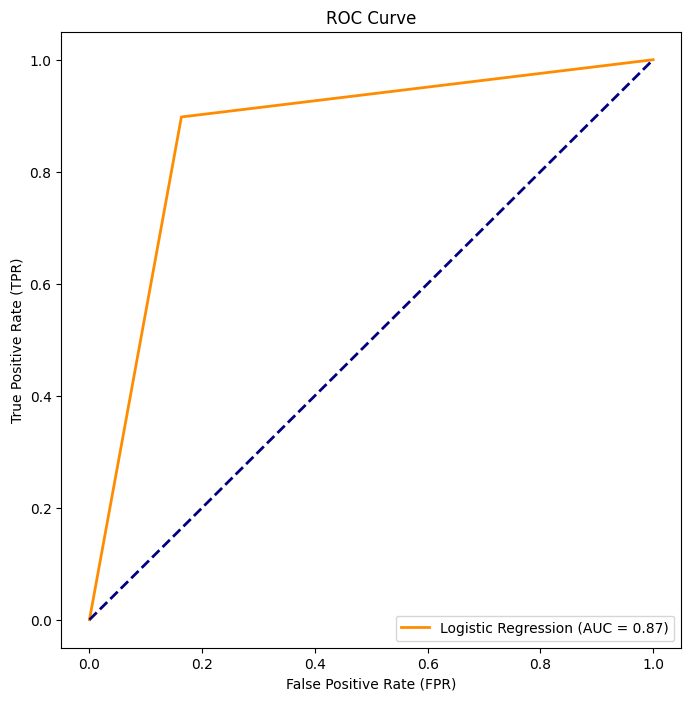

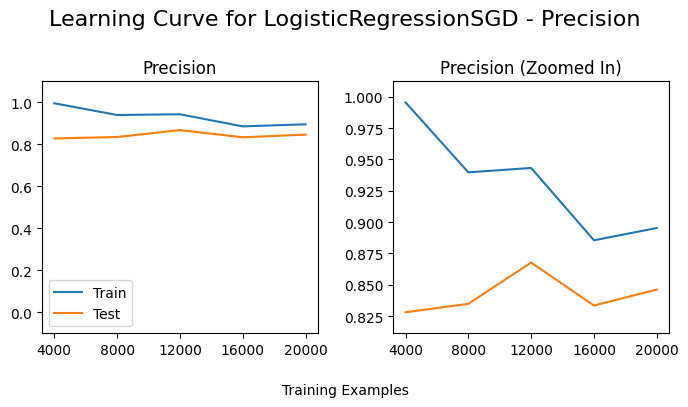

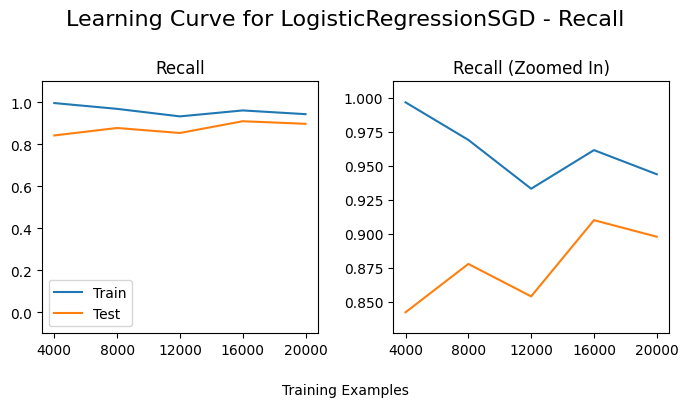

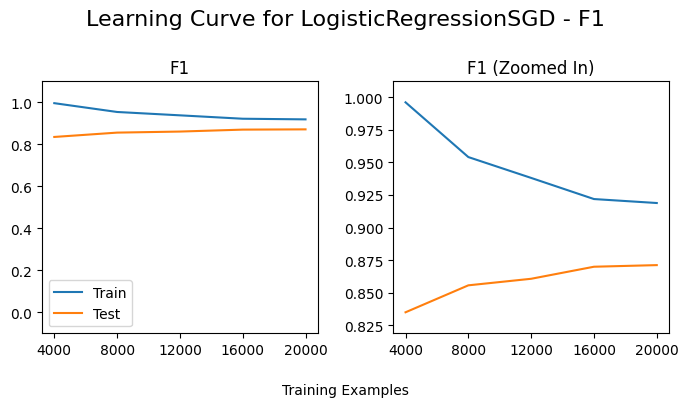

In [10]:
from sklearn.metrics import classification_report

# Train the Logistic Regression model on the training data with the best lambda and threshold values
logreg_data = evaluate_estimator(LogisticRegressionSGD(lambda_value=best_lambda, threshold=best_threshold), x_train_binary, y_train, x_test_binary, y_test, 5)

# Display classification report for the test set
print(classification_report(y_test, logreg_data['test_pred']))

# Display metrics summary table
plot_metrics_table(logreg_data)

# Plot ROC curve
plot_roc_curve(y_test, logreg_data['test_pred'], label='Logistic Regression')

# Plot learning curves to visualize training and testing performance
plot_learning_curves(logreg_data)

### Logistic Regression against SciKitLearn's Logistic Regression

,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
4000,0.00,0.02,0.00,0.01,0.00,0.02
8000,-0.05,-0.01,-0.01,0.07,-0.03,0.04
12000,-0.03,0.02,-0.02,0.02,-0.02,0.02
16000,-0.06,-0.02,0.02,0.06,-0.02,0.02
20000,-0.03,0.00,0.00,0.04,-0.01,0.01


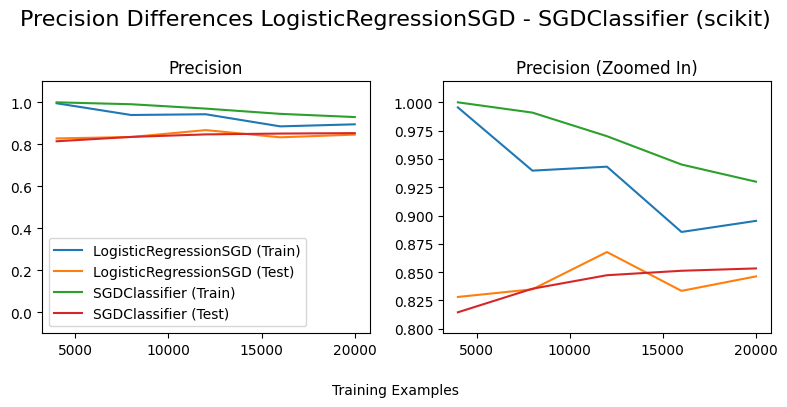

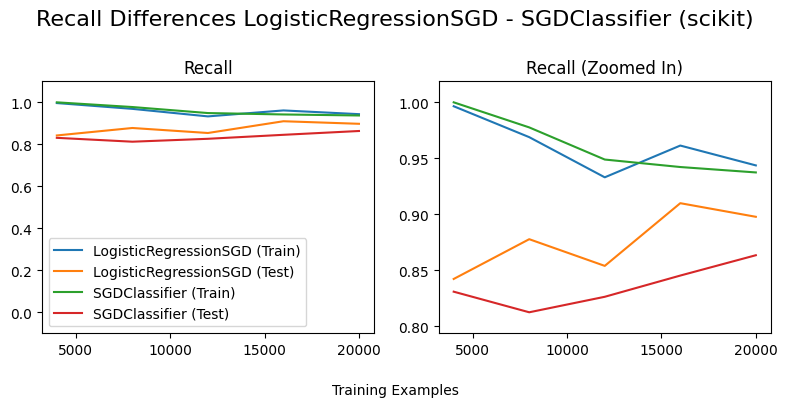

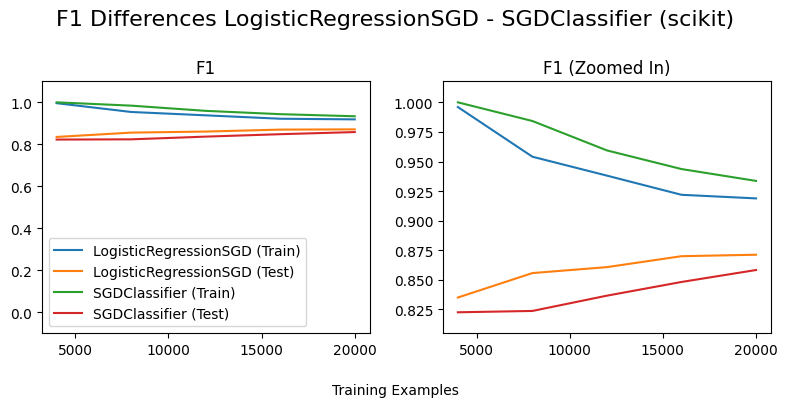

In [13]:
from sklearn.linear_model import SGDClassifier

# Evaluate the scikit-learn Logistic Regression model
scikit_logreg_data = evaluate_estimator(SGDClassifier(loss='log_loss'), x_train_binary, y_train, x_test_binary, y_test, 5)

# Compare metrics and plot differences
plot_metrics_table_differences(logreg_data, scikit_logreg_data)
plot_learning_curve_differences(logreg_data, scikit_logreg_data)

### Logistic Regression against SKLearn's Bernoulli Naive Bayes 

,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
4000,0.12,0.00,0.12,0.00,0.12,0.01
8000,0.09,0.00,0.10,0.04,0.09,0.02
12000,0.09,0.03,0.06,0.01,0.08,0.02
16000,0.04,-0.01,0.09,0.07,0.06,0.03
20000,0.05,0.01,0.07,0.06,0.06,0.03


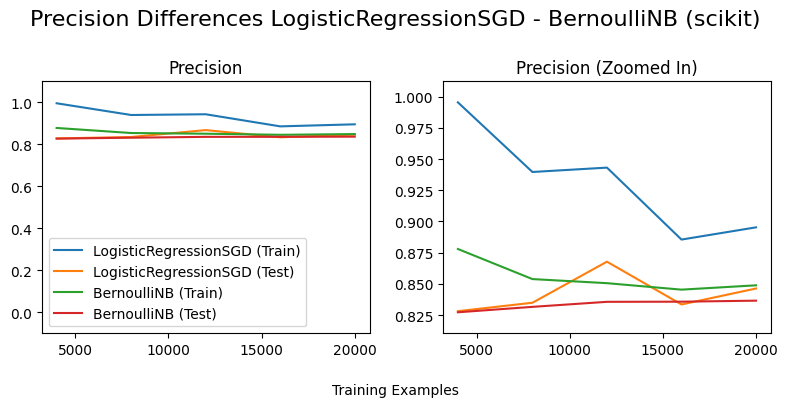

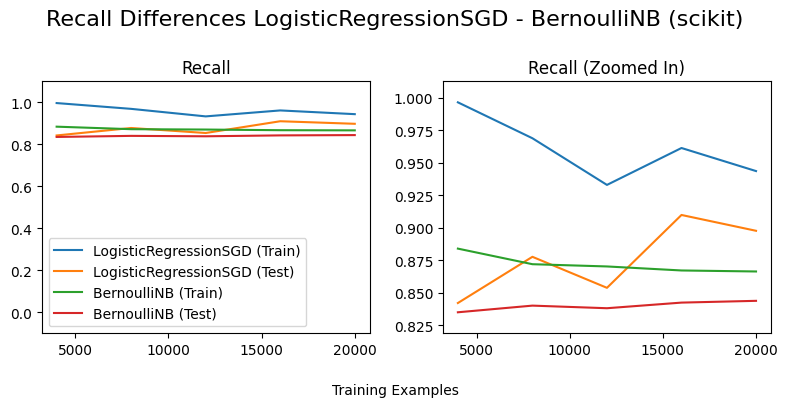

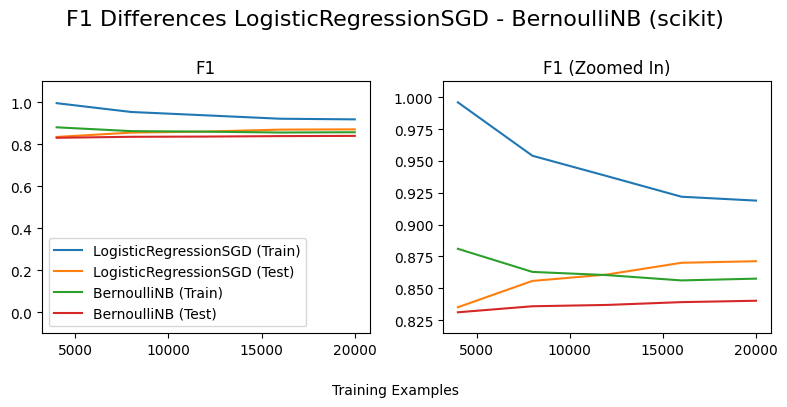

In [14]:
from sklearn.naive_bayes import BernoulliNB

# Evaluate the scikit-learn Bernoulli Naive Bayes model
scikit_bnb_data = evaluate_estimator(BernoulliNB(), x_train_binary, y_train, x_test_binary, y_test, 5)

# Compare metrics and plot differences
plot_metrics_table_differences(logreg_data, scikit_bnb_data)
plot_learning_curve_differences(logreg_data, scikit_bnb_data)

### Logistic Regression against SKLearn's Ada Boost

,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
4000,0.25,0.10,0.19,0.05,0.22,0.08
8000,0.22,0.11,0.13,0.04,0.17,0.09
12000,0.20,0.13,0.11,0.03,0.16,0.08
16000,0.14,0.08,0.17,0.13,0.15,0.10
20000,0.15,0.10,0.16,0.13,0.15,0.11


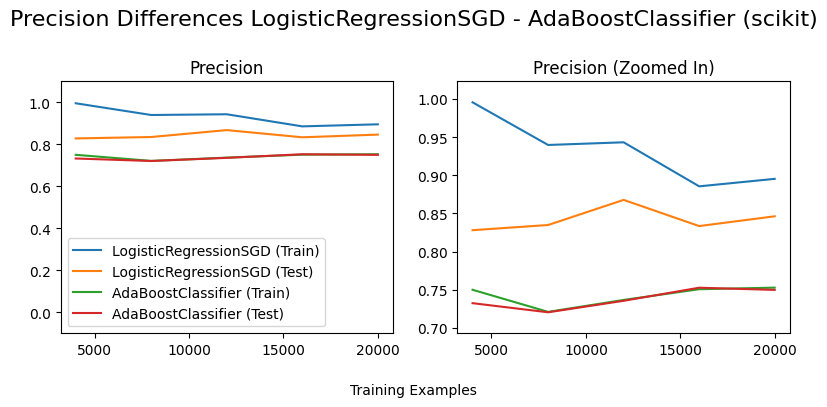

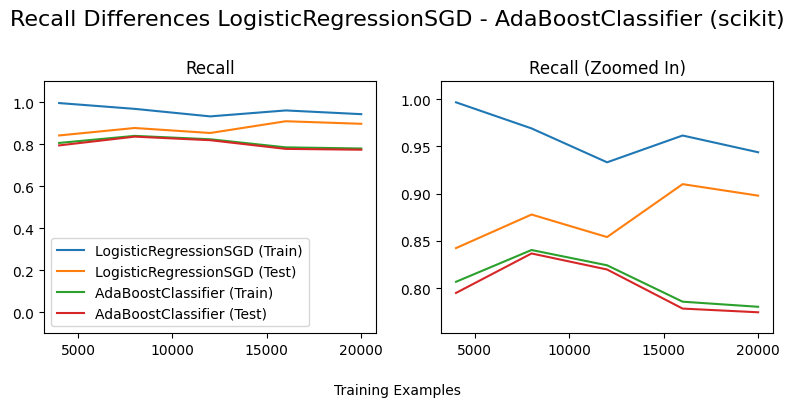

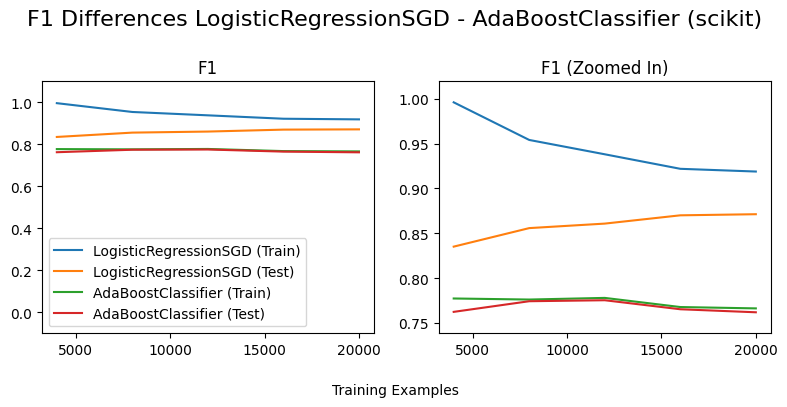

In [15]:
from sklearn.ensemble import AdaBoostClassifier

# Evaluate the scikit-learn AdaBoost model
scikit_ab_data = evaluate_estimator(AdaBoostClassifier(), x_train_binary, y_train, x_test_binary, y_test, 5)

# Compare metrics and plot differences
plot_metrics_table_differences(logreg_data, scikit_ab_data)
plot_learning_curve_differences(logreg_data, scikit_ab_data)